In [0]:
#thailand weather
thailand = ["samut_prakan", "nonthaburi", "chiang_mai", "phuket", "krabi", "udon_thani", "songkhla", "nakhon_ratchasima", "pattani", "nakhon_patthom","phitsanulok","bkk_weather"]

# "phang Nga": (17.3850, 99.8332), "Jakarta": (6.1944, 106.8229), "Surabaya": (-7.2458,112.7378), "Medan": (3.5894,98.6739),"Malang":(-7.9800,112.6200), "Kuala Lumpur":(3.1478,101.6953),"Seberang Jaya":(5.4083,100.3695), "Klang":(3.0333,101.4500), "Ipoh":	(4.5972,101.0750), "George Town":(5.4144,100.3292), "Ho Chi Minh City":(10.7756,106.7019),"Hanoi":(21.0000,105.8500), "Haiphong":(208651,106.6838),"Can Tho": (10.0333,105.7833), "Bien Haa":(10.9500,106.8167), "Rangoon":(16.7950,96.1600), "Mandalay":(21.9831,96.0844),"Nay Pyi Taw": (19.7475,96.1150), "Kyaukse":(21.6131,96.1303),"Hpa An":(16.8906,97.6333), "Phnom Penh":(11.5694,104.9211), "Siem Reap":(13.3622,103.8597), "Battambang":(13.1000,103.2000), "Kampong Cham":(11.9870,105.4620), "Sisophon":(13.5833,102.9833), "Manila":(14.5958,120.9772),"Quezon City":(14.6500,121.0475),"Zamboanga City":(6.9042,122.0761), "Davao":(7.0700,125.6000),"Caloocan City":(14.6500,120.9700), "Cebu":(10.3167,123.8833),"Vientiane":(17.9800,102.6300),"Xiangkhoang":(19.4167,103.5000), "Savannakhet":(16.5500,104.7500),"Salavan":(15.7167,106.4167), "Phitsanulok":(16.8200,100.2600),"Singapore":(1.3000,103.8000)}

from matplotlib import pyplot as plt
from pyspark.sql import functions as F
import pyspark.pandas as ps

bkk = spark.sql("SELECT * FROM bkk_weather")


def pandas_plus(pser,i:int):
        return pser + 30*i

plt.figure(figsize=(300,50))

# for i,ele in enumerate(thailand):
#     print(ele)
#     df = spark.sql(f"SELECT * FROM {ele}")
#     df = df.toPandas()
#     display(df)
    # plt.plot(df["date"], df["temperature_2m"].apply(lambda x: x + 30*i), label=ele)

df = spark.sql(f"SELECT * FROM chiang_mai where year > 2012")
#display(df)
df = spark.sql(f"SELECT * FROM bkk_weather where year > 2012")
#display(df)

# plt.legend()
# plt.show()


<Figure size 30000x5000 with 0 Axes>

In [0]:
traffic = spark.sql("""
SELECT 
    date_format(dates, 'yyyy-MM-dd HH:00:00') as my_date, 
    index
FROM 
    bkk_traffic 
""")
#display(traffic)
traffic = traffic.toPandas()

traffic = traffic.groupby('my_date', as_index=False).mean()
#print(merge)


Join the Tables of Weather and Traffic together

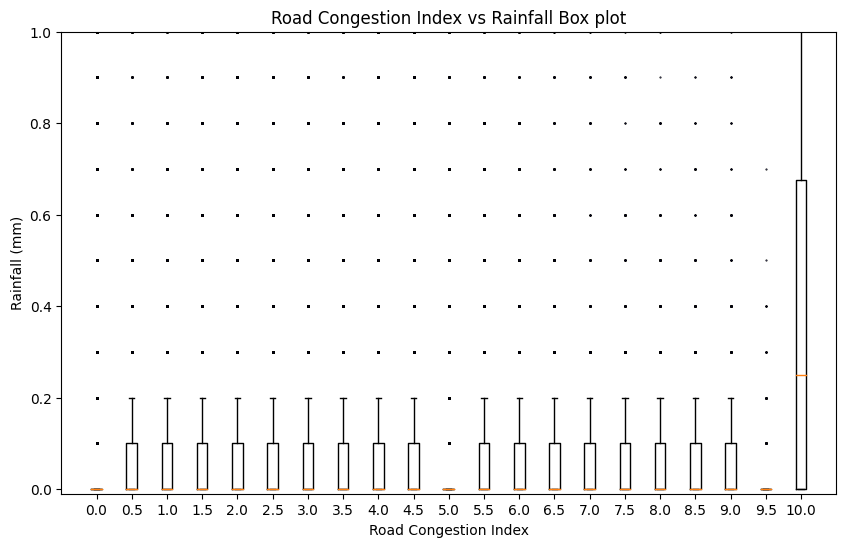

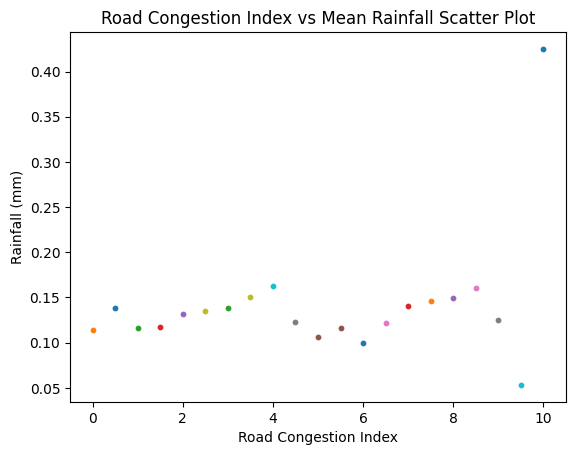

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
bkk_weather = spark.sql("SELECT dates as my_date, rain,temperature_2m,cloud_cover,wind_speed_10m FROM bkk_weather")
bkk_weather = bkk_weather.toPandas()
import numpy as np
#display(bkk_weather)
#bkk_weather.join(traffic, df1['key'] == df2['key'], 'inner')


merge = pd.merge(traffic, bkk_weather, on=["my_date"], how='inner')
#merge = traffic.merge(bkk_weather, left_on='avg_index', right_on='my_date')

#merge["index"] = merge["index"].apply(lambda x: 0.5 * np.round(x / 0.5))
merge["index"] = merge["index"].apply(lambda x: 0.5 * np.round(x / 0.5))
plt.figure(figsize=(10,6))
plt.ylim(-0.01,1)
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['rain'].values
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.boxplot(data_to_plot, positions=[elt],flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'blue'})  

plt.title("Road Congestion Index vs Rainfall Box plot")
plt.xlabel("Road Congestion Index")
plt.ylabel("Rainfall (mm)")
plt.show()
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['rain'].values.mean()
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.scatter(elt, data_to_plot,s = 10)

plt.title("Road Congestion Index vs Mean Rainfall Scatter Plot")
plt.xlabel("Road Congestion Index")
plt.ylabel("Rainfall (mm)")
plt.show()



In [0]:
from scipy import stats
obs = merge["index"]
result = stats.ks_1samp(obs, stats.norm.cdf, args=(np.mean(obs), np.std(obs)))
print(result.pvalue)
# cant reject null hypothesis meaning its not normally distributed

result = stats.kruskal(
    *[merge[merge['index'] == i]["rain"] for i in np.unique(merge["index"])])
print(result.pvalue)
# can reject H0, and there's significant difference between median value of each traffic index 

0.0
5.077098514446864e-18


[13  0 11 ... 12  9  7]


Text(0.5, 1.0, 'Accuracy Score: 0.1386735852116102')

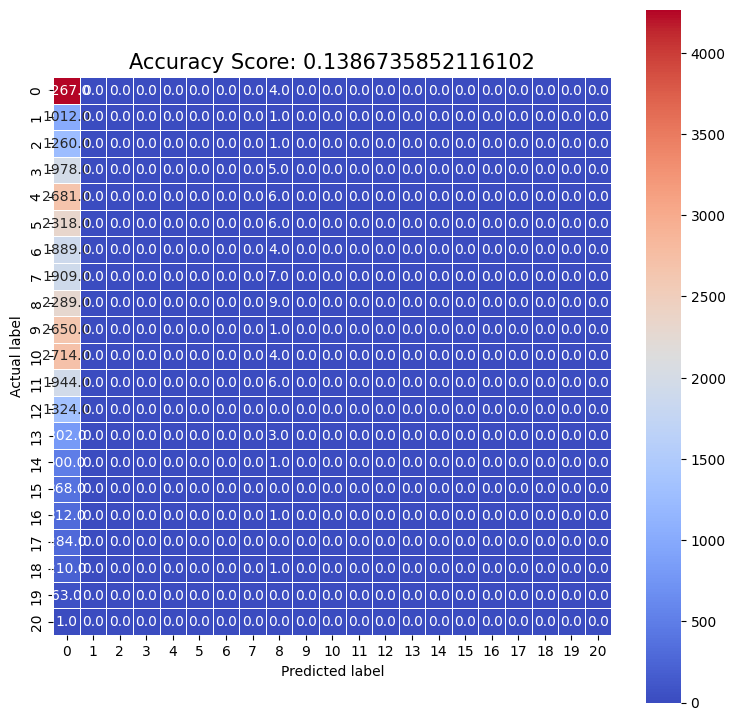

In [0]:
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
import seaborn as sns

merge2 = merge #[(merge["rain"] <= 0.1) & (merge["index"] <= 3)]
X = merge2["rain"].values.reshape(-1, 1)
Y = merge2["index"].apply(lambda x: int(x*2))
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)
print(y_test.values)
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(c, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'coolwarm')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = log_model.score(X_test, y_test)
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)



/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[13  0 11 ... 12  9  7]


Text(0.5, 1.0, 'Accuracy Score: 0.13851143181449652')

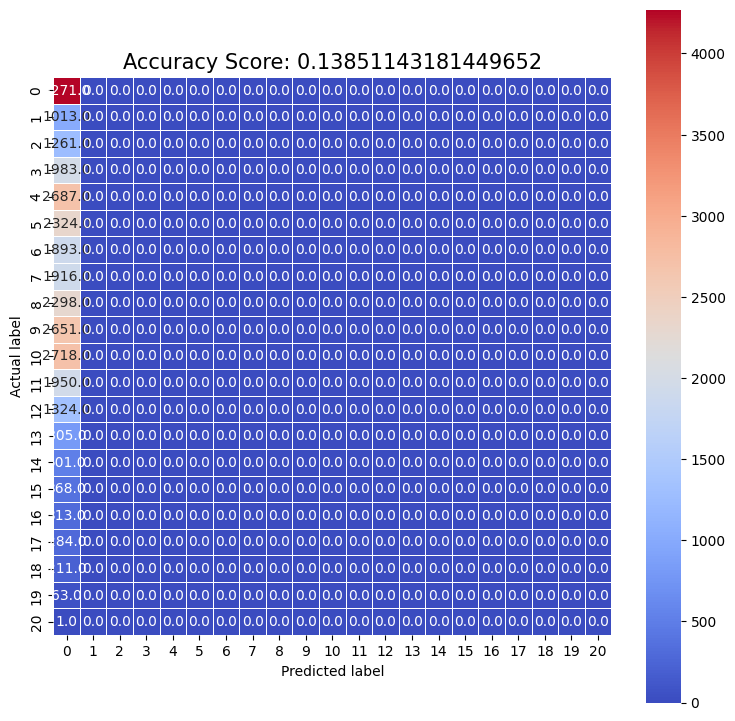

In [0]:
X = merge2["cloud_cover"].values.reshape(-1, 1)
Y = merge2["index"].apply(lambda x: int(x*2))
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)
print(y_test.values)
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(c, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'coolwarm')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = log_model.score(X_test, y_test)
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

In [0]:
X = merge2["temperature_2m"].values.reshape(-1, 1)
Y = merge2["index"].apply(lambda x: int(x*2))
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
predictions = log_model.predict(X_test)
print(y_test.values)
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_test, predictions)

plt.figure(figsize=(9,9))
sns.heatmap(c, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'coolwarm')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = log_model.score(X_test, y_test)
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

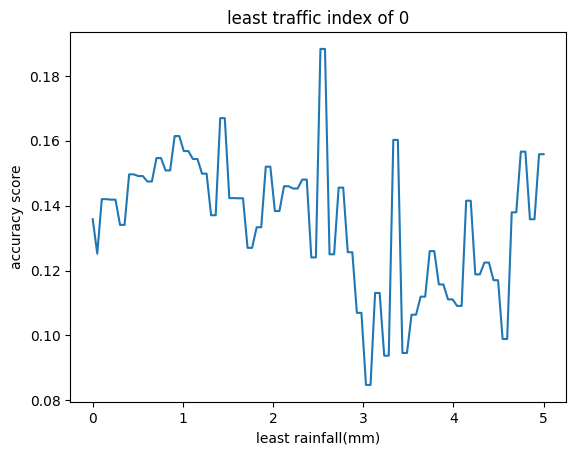

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

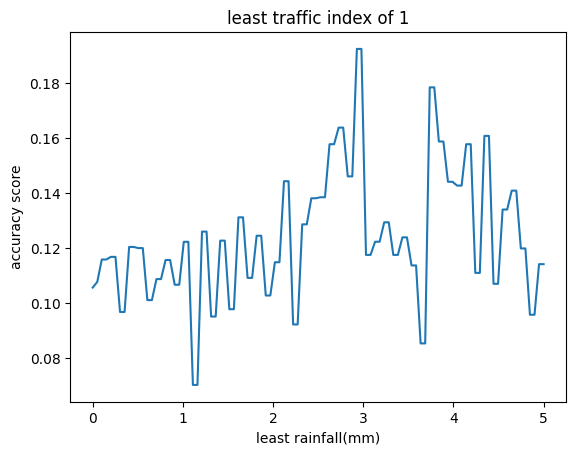

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

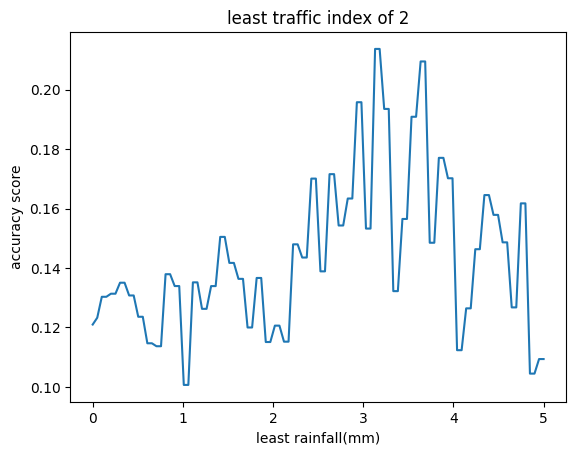

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

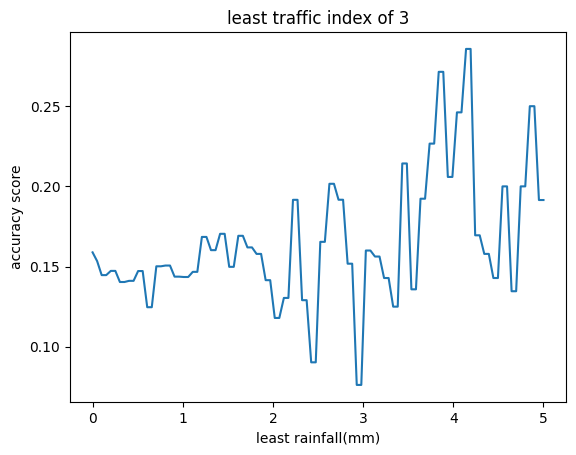

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

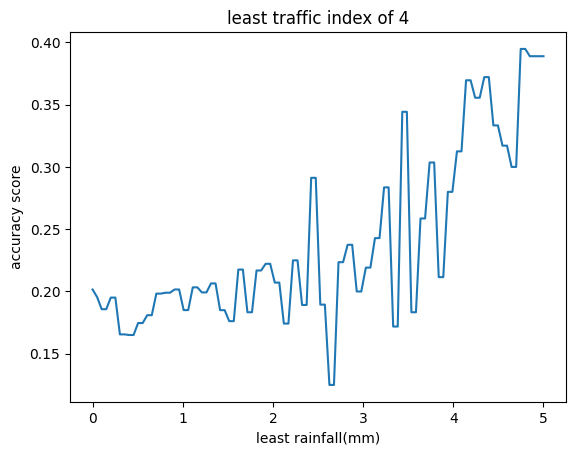

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

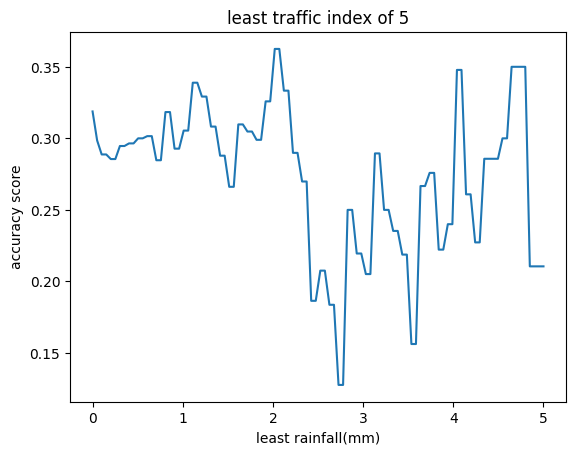

/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/databricks/python/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

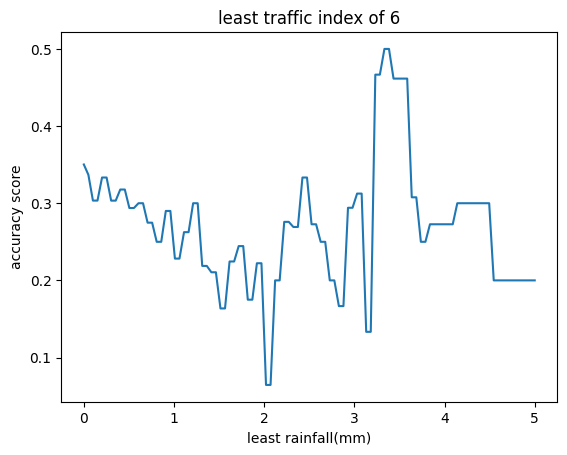

In [0]:
#finding right condition

def find(i,i2):
    merge2 = merge[(merge["rain"] >= i) & (merge["index"] >= i2)]
    X = merge2["rain"].values.reshape(-1, 1)
    Y = merge2["index"].apply(lambda x: int(x*2))
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state = 0)
    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)
    score = log_model.score(X_test, y_test)
    return score

line = np.linspace(0, 5, 100)
# score = [find(i,6) for i in line]
# plt.plot(line, score)

for i2 in range(7):
    score = [find(i,i2) for i in line]
    plt.xlabel("least rainfall(mm)")
    plt.ylabel("accuracy score")
    plt.title(f"least traffic index of {i2}")
    plt.plot(line, score)
    plt.show()


In [0]:
find(2.5,6)

0.75

In [0]:
print(metrics.classification_report(y_test, log_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.14      0.94      0.24      1536
           1       0.00      0.00      0.00       233
           2       0.00      0.00      0.00       255
           3       0.00      0.00      0.00       633
           4       0.21      0.07      0.11       970
           5       0.00      0.00      0.00       899
           6       0.00      0.00      0.00       677
           7       0.00      0.00      0.00       707
           8       0.00      0.00      0.00       736
           9       0.05      0.01      0.01       953
          10       0.00      0.00      0.00       990
          11       0.00      0.00      0.00       766
          12       0.00      0.00      0.00       534
          13       0.00      0.00      0.00       344
          14       0.00      0.00      0.00       195
          15       0.00      0.00      0.00       130
          16       0.00      0.00      0.00       118
          17       0.00    

/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


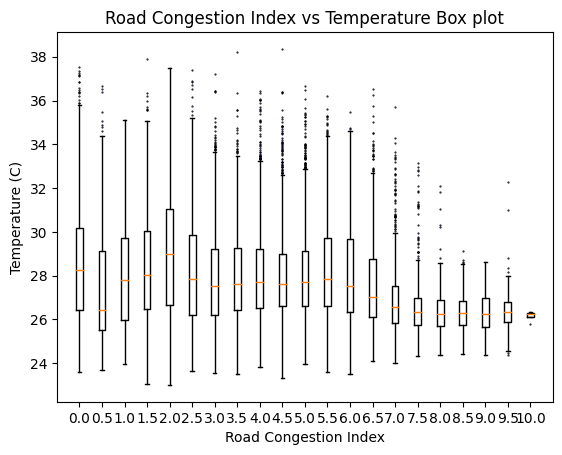

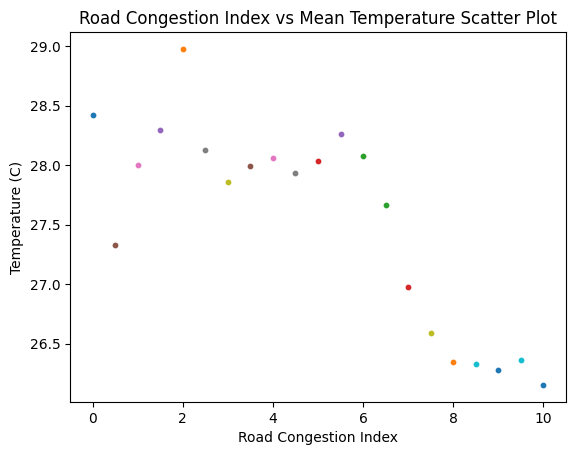

In [0]:
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['temperature_2m'].values
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.boxplot(data_to_plot, positions=[elt],flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'blue'})  # Specify positions if needed
# plt.scatter(merge["index"].apply(lambda x: round(x)), merge["rain"],s = 10)
# plt.legend()
plt.xlabel("Road Congestion Index")
plt.ylabel("Temperature (C)")
plt.title("Road Congestion Index vs Temperature Box plot")
plt.show()
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['temperature_2m'].values.mean()
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.scatter(elt, data_to_plot,s = 10)

plt.title("Road Congestion Index vs Mean Temperature Scatter Plot")
plt.xlabel("Road Congestion Index")
plt.ylabel("Temperature (C)")
plt.show()

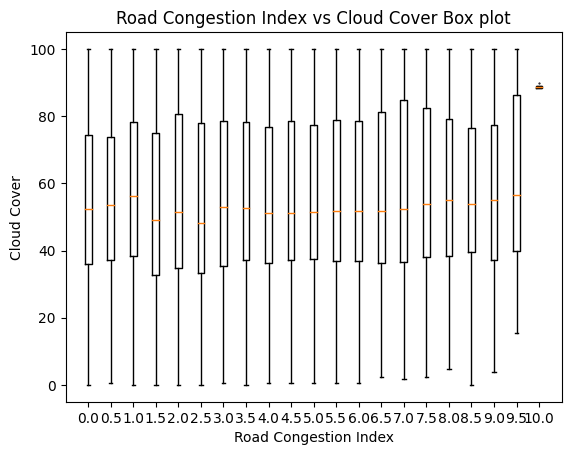

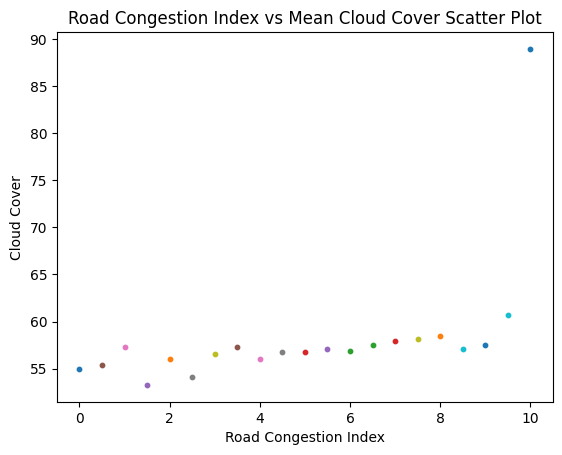

In [0]:
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['cloud_cover'].values
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.boxplot(data_to_plot, positions=[elt],flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'blue'})  # Specify positions if needed
# plt.scatter(merge["index"].apply(lambda x: round(x)), merge["rain"],s = 10)
# plt.legend()
plt.xlabel("Road Congestion Index")
plt.ylabel("Cloud Cover")
plt.title("Road Congestion Index vs Cloud Cover Box plot")
plt.show()
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['cloud_cover'].values.mean()
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.scatter(elt, data_to_plot,s = 10)

plt.title("Road Congestion Index vs Mean Cloud Cover Scatter Plot")
plt.xlabel("Road Congestion Index")
plt.ylabel("Cloud Cover")
plt.show()


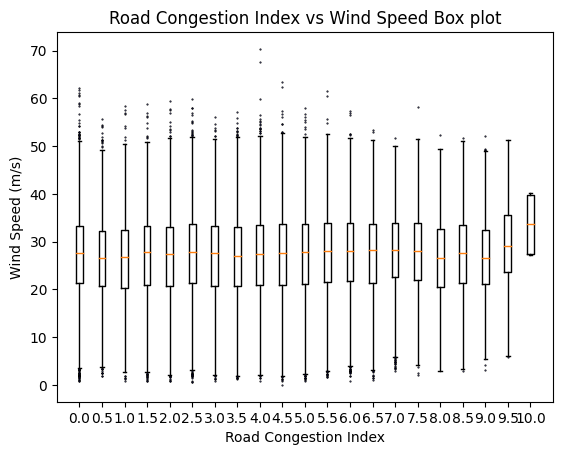

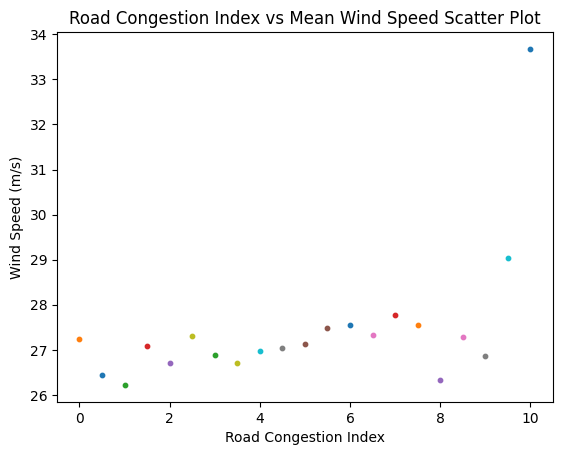

In [0]:
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['wind_speed_10m'].values
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.boxplot(data_to_plot, positions=[elt],flierprops={'marker': '.', 'markersize': 1, 'markerfacecolor': 'blue'}) 

plt.xlabel("Road Congestion Index")
plt.ylabel("Wind Speed (m/s)")
plt.title("Road Congestion Index vs Wind Speed Box plot")
plt.show()
for i,elt in enumerate(list(merge["index"].unique())):
    data_to_plot = merge[merge["index"] == elt]['wind_speed_10m'].values.mean()
    # Ensure data is in a list of arrays format, each array representing a dataset for a single boxplot
    plt.scatter(elt, data_to_plot,s = 10)
plt.title("Road Congestion Index vs Mean Wind Speed Scatter Plot")
plt.xlabel("Road Congestion Index")
plt.ylabel("Wind Speed (m/s)")
plt.show()

In [0]:
pdf = pd.read_csv(url)
pdf





Crash_Ref_Number  ... Count_Unit_Other
0                      1  ...                0
1                      2  ...                0
2                      3  ...                0
3                      4  ...                0
4                      5  ...                0
...                  ...  ...              ...
386832            386834  ...                0
386833            386835  ...                0
386834            386836  ...                0
386835            386837  ...                0
386836            386838  ...                0

[386837 rows x 52 columns]

In [0]:
# %sql
# select * from bkk_event


incident = spark.sql("""
SELECT title, 
       description,
       date_format(
           to_timestamp(concat(date, ' ', time), 'yyyy-MM-dd HH:mm:ss'), 
           'yyyy-MM-dd HH:00:00'
       ) AS my_date 
FROM bkk_event
""")
display(incident)
incident = incident.toPandas()

# text = " ".join(review for review in df_deal.category.astype(str))
# text_nodeal = " ".join(review for review in df_nodeal.category.astype(str))
# wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
# wordcloud_nodeal = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text_nodeal)




title description my_date การจัดงาน BOI Fair (การจัดงาน) งาน BOI Fair ระว่างวันที่ 5-20 ม.ค.2555 ที่เมืองทองธานี(แจ้งให้ทราบเป็นข้อมูล) 2012-01-05 00:00:00 การจัดงาน แต่งงาน คุณโสพิศ ธ.กสิกร สาขาบางขุนนนท์ ต.แพรกศรีราชา อ.สรรคบุรี จ.ชัยนาท 17140 2012-01-08 00:00:00 รถติด ถนนเชื่อมต่อ null 2012-01-01 12:00:00 รถติด ถนนเชื่อมต่อ null 2012-01-02 11:00:00 การจราจรหนาแน่น ถนนกำแพงเพชร 2 (การจราจรหนาแน่น) ถนนกำแพงเพชร 2 ช่วงหน้าหมอชิต มีการจราจรหนาแน่น ชลอตัวหน้า สถานีขนส่งหมอชิต (แจ้งให้ทราบเป็นข้อมุล) 2012-01-03 06:00:00 อุบัติเหตุ ถนนงามวงศ์วาน (อุบัติเหตุ) บริเวณอยู่ใต้ทางด่วนงามวงศ์วาน มุ่งหน้า แคราย เตือนพบอุบัติเหตุ ยนต์นั่งส่วนบุคคลชนกันประมาณ 2 คัน เนื่องจากรถยนต์นัี่งส่่วนบุคคล 1 คันอยู่ช่องทางซ้าย ส่วนอีก 1 คัน อยู่ช่องทางขวาให้ผู้ใช้รถระมัดระวัง อย่าขับด้วยความเร็ว ให้ชะลอเพื่อความปลอดภัย(แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 06:00:00 การจราจรหนาแน่น ถนนกำแพงเพชร 6 (ถนนเลียบทางรถไฟ) (การจราจรหนาแน่น) ถนนกำแพงเพชร 6 (ถนนเลียบทางรถไฟ) มุ่งหน้าถนนกำแพงเพชร 2 มีปริมารรถมาก การจราจรหนาแน่น เนื่องจากรถโดยสารสายต่างๆ ทุกสายจะต้องเข้าไปจอดที่ชานชลา ขนส่งหมอชิต 2 (แจ้งให้ผู้ใช้เส้นทางทราบเป็นข้อมูล) 2012-01-03 06:00:00 การจราจรหนาแน่น ทางเลียบถนนพหลโยธิน (การจราจรหนาแน่น) การจราจรหนาแน่น ทางเลียบเมืองพหลโยธิน จากสระบุรีหน้าค่ายอดิสร มุ่งหน้า วหนองแค อ.วังน้อย มีรถมาก การจราจรหนาแน่น เคลื่อนตัวได้ช้า (แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 06:00:00 การจราจรหนาแน่น ทางเลี่ยงเมืองสระบุรี (การจราจรหนาแน่น) ทางเลี่ยงเมืองสระบุรี มีปริมาณรถมาก การจราจรหนาแน่น เคลื่องตัวได้ช้า (แจ้งให้คราบเป็นข้อมูล) 2012-01-03 06:00:00 การจราจรหนาแน่น ถนนพหลโยธิน (การจราจรหนาแน่น) (การจราจรหนาแน่น) บริเวณถนนพหลโยธิน ซึ่งเป็นที่ตั้งของเมเจอร์รังสิต ขณะนี้มีปริมาณรถมาก การจราจรหนาแน่น เคลื่อนตัวได้ช้า เนื่องจากรถจอดส่งคนที่กลับจากกรเดินทางจากต่างจังหวัดในช่วงเทศกาลปีใหม่ เป็นจำนวนมาก (แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 07:00:00 ข่าวประกาศ เตือน 5 จังหวัด ภาคใต้ฝนตกหนัก อาจมีน้ำท่วมฉับพลันบางพื้นที่ (ข่าวประกาศ) เตือน 5 จังหวัด ภาคใต้ฝนตกหนัก อาจมีน้ำท่วมฉับพลันบางพื้นที่
 null null null null null 99.064557538548 null ระวัง ถนนเกษตร - นวมินทร์ (ระวัง) เส้นเกษตรนวมินทร์ แยกเลียบทางด่วน พบสัญญาณไฟอดง ค้าง อาจส่งผลต่อผู้สัญจรไปมาและการขับขี่ได้ เบื้องต้นประสานเจ้าหน้าที่แล้ว และอยู่ระหว่างดำเนินการ (แจ้งเตือนให้ผู้ขับขี่ระวังด้วย) 2012-01-03 07:00:00 การจราจรหนาแน่น ถนนวิภาวดีรังสิต (การจราจรหนาแน่น) ถนนวิภาวดีช่วงก่อนถึงแยกลาดพร้าว การจราจรหนาแน่น เริ่มมีรถบัสมาจอดส่งประชาชน กลับเข้ากทม.(แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 07:00:00 การจราจรหนาแน่น ถนนเพชรบุรีตัดใหม่ (การจราจรหนาแน่น) ถนนเพชรบุรีตัดใหม่ (ขาเข้า) ปริมาณรถเริ่มมาก และจากคลองตัน มุ่งหน้า โรงแรมอามารี การจราจรเริ่มติดขัดแล้ว (แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 07:00:00 การจราจรหนาแน่น ถนนบรมราชชนนี (การจราจรหนาแน่น) ถนนบรมราชชนนี ช่วงสายใต้ใหม่ ปริมาณรถมาก การจราจรหนาแน่น เคลื่อนตัวได้ช้า (แจ้งให้ผู้ใช้เส้นทางทราบเป็นข้อมูล) 2012-01-03 07:00:00 อุบัติเหตุ ถนนกัลปพฤกษ์ (อุบัติเหตุ) ถนนกัลปพฤกษ์ขาเข้า บริเวณหน้าหมู่บ้านเมโทรปาร์คสาทร เป็นรถยนต์นั่งสาธารณะ 2 คัน ชนกับรถจักรยานยนต์ 
 null null 100.45305131468 null น้ำท่วม จังหวัดนครศรีธรรมราช (น้ำท่วม) จังหวัดนครศรีธรรมราช มุ่งหน้ากรุงเทพฯ รถเล็กไม่สามารถวิ่งผ่านได้ เนื่องจากมีระดับน้ำท่วมสูง รถกระบะยกสูง ยังวิ่งผ่านลำบาก เพราะฉะนั้นแนะนำให้เดินทาง โดยใช้รถทัวร์แทน(แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 07:00:00 ระวัง ทางหลวงแผ่นดินหมายเลข 4232 ขนอม –สิชล (ระวัง) ทางหลวงแผ่นดินหมายเล4232 ขนอม –สิชล น้ำท่วม ทางขาดผ่านไม่ได้ (แจ้งเตือนให้ผู้ใช้เส้นทางทราบเป็นข้อมูล) 2012-01-03 08:00:00 อุบัติเหตุ ถนนสาทรใต้ (อุบัติเหตุ) บริเวณถนนสาทรใต้ ช่วงหน้า โรงพยาบาลบางรักพบอุบัติเหตุรถกระบะ ชนกับรถยนต์นั่งส่วนบุคคล เบื้องต้นประสานเจ้าหน้าที่แล้ว (แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 08:00:00 อุบัติเหตุ ถนนเพชรเกษม (อุบัติเหตุ) ถนนเพชรเกษม มาจากถนนพุทธมณฑลสาย 4 ก่อนถึงแยกเพชรเกษม 50 เมตร มีอุบัติเหตุรถกระบะยี่ห้อโตโยต้าวีโก้ สีขาว เสียหลักชนเสาป้ายบอกทาง เจ้าหน้าที่ตำรวจและกู้ภัยอยู่ระหว่างดำเนินการ (แจ้งให้ทราบเป็นข้อมูล) 2012-01-03 08:00:00 อุบัติเหตุ ถนนบรมราชชนนี (อุบัติเหุต) ถนนบรมราชชนนี ขาออก ลงจากต่างระดับฉิมพลีเล็กน้อย มีรถกะบะตกถนน มีคนเจ็บ(แจ้งให้ทราบเป็นข้อมุล) 2012-01-03

In [0]:
weather_ind = pd.merge(bkk_weather, incident, on=["my_date"], how='inner')

weather_ind
# text = " ".join(review for review in df_deal.category.astype(str))
# text_nodeal = " ".join(review for review in df_nodeal.category.astype(str))
# wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
# wordcloud_nodeal = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text_nodeal)


my_date  ...                                        description
0       2018-08-06 11:00:00  ...  เกิดอุบัติเหตุ ข้อมูลจาก บริษัท กลางคุ้มครองผู...
1       2018-08-06 11:00:00  ...  เกิดอุบัติเหตุ ข้อมูลจาก บริษัท กลางคุ้มครองผู...
2       2018-08-06 11:00:00  ...  เกิดอุบัติเหตุ ข้อมูลจาก บริษัท กลางคุ้มครองผู...
3       2018-08-06 11:00:00  ...  เกิดอุบัติเหตุ ข้อมูลจาก บริษัท กลางคุ้มครองผู...
4       2018-08-06 11:00:00  ...  เกิดอุบัติเหตุ ข้อมูลจาก บริษัท กลางคุ้มครองผู...
...                     ...  ...                                                ...
355640  2012-05-24 19:00:00  ...  (การจราจรหนาแน่น)  ถนนรัชดาภิเษก ช่วงแยกฟอร์จู...
355641  2012-05-24 19:00:00  ...  (อุบัติเหต)  ถ.พัฒนาการ ขาออก อยู่ตรงข้ามกับพั...
355642  2012-05-24 19:00:00  ...  (การจราจรหนาแน่น) ถนนรัชดาภิเษกขาเข้าจากห้วยขว...
355643  2012-05-24 19:00:00  ...  (การจราจรหนาแน่น)  ถนนพระราม 9 มุ่งหน้าแยก อสม...
355644  2012-05-24 19:00:00  ...  (การจราจรหนาแน่น)  ถนนบรมราชชนนี ขาออก ช่วงปิ่...

[355645 rows x 7 columns]

(array([2.09855e+05, 4.06100e+03, 1.62300e+03, 7.51000e+02, 3.34000e+02,
        2.01000e+02, 1.24000e+02, 8.80000e+01, 5.70000e+01, 3.90000e+01,
        5.00000e+01, 3.10000e+01, 2.50000e+01, 2.60000e+01, 1.30000e+01,
        1.40000e+01, 1.00000e+01, 8.00000e+00, 5.00000e+00, 7.00000e+00,
        6.00000e+00, 5.00000e+00, 5.00000e+00, 3.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

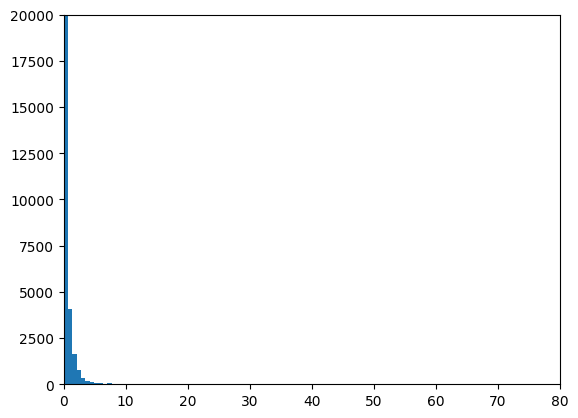

In [0]:
plt.xlim(0,80)
plt.ylim(0,20000)
plt.hist(bkk_weather["rain"],bins =100)


In [0]:
# text = " ".join(review for review in df_deal.category.astype(str))
# text_nodeal = " ".join(review for review in df_nodeal.category.astype(str))
# wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
# wordcloud_nodeal = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text_nodeal)
!pip install pythainlp
!pip install wordcloud
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud

# rain_high = weather_ind[weather_ind["rain"] > 0.4]
# text = word_tokenize(" ".join(review for review in rain_high["description"].astype(str)), engine='newmm')
# wordcloud = WordCloud(stopwords=thai_stopwords(), background_color="white", width=800, height=400).generate(text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()



  Obtaining dependency information for pythainlp from https://files.pythonhosted.org/packages/af/23/439ff7a361b2d022a2a63d4ec610359afe0123a419bcd86fca4fec6f1ba5/pythainlp-5.0.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/17.9 MB ? eta -:--:--
   ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/17.9 MB 8.1 MB/s eta 0:00:03
   ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/17.9 MB 43.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 8.8/17.9 MB 86.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 16.8/17.9 MB 220.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 17.9/17.9 MB 217.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 17.9/17.9 MB 217.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 88.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for wordcloud fro

In [0]:
rain_high = weather_ind[weather_ind["rain"] > 0.4]
text = " ".join(review for review in rain_high["description"].astype(str))

In [0]:
text = word_tokenize(text, engine='newmm')

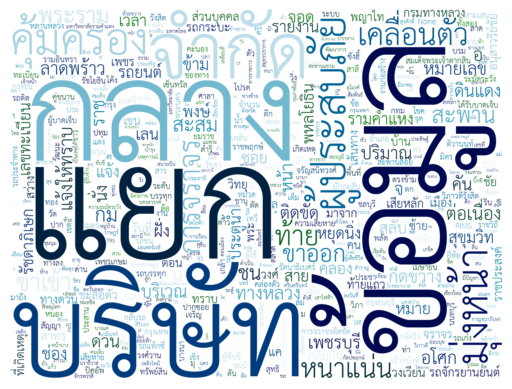

In [0]:
path = '/Volumes/data_mining_47366414998805/default/store_data/data_storage/THSarabunNew.ttf'

stop = set(thai_stopwords())
stop.add("รถ")
stop.add("อบัติเหต")
stop.add("ถนน")
stop.add("อบัติเหตุ")
stop.add("อุบัติเหตุ")
wordcloud = WordCloud(
                      font_path = path,
                      stopwords=stop, # stop words ที่ใช้ซึ่งจะโดนตัดออกและไม่แสดงบน words cloud 
                      relative_scaling=0.3,
                      min_font_size=1,
                      background_color = "white",
                      width=1024,
                      height=768,
                      max_words=500, # จำนวนคำที่เราต้องการจะแสดงใน Word Cloud
                      colormap='ocean_r', 
                      scale=3,
                      font_step=4,
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+", # Regular expression to split the input text into token
                      margin=2).generate(' '.join(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


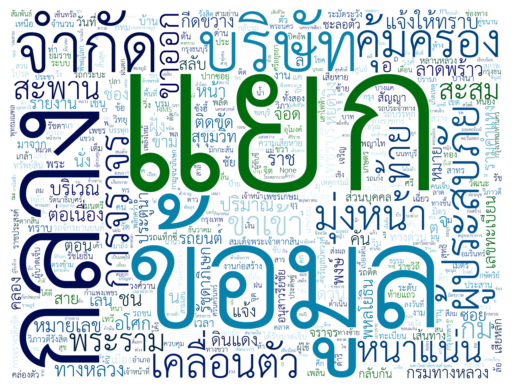

In [0]:
rain_high_med = weather_ind[weather_ind["rain"] > 0.2]
text = " ".join(review for review in rain_high_med["description"].astype(str))
text = word_tokenize(text, engine='newmm')
wordcloud = WordCloud(
                      font_path = path,
                      stopwords=stop, # stop words ที่ใช้ซึ่งจะโดนตัดออกและไม่แสดงบน words cloud 
                      relative_scaling=0.3,
                      min_font_size=1,
                      background_color = "white",
                      width=1024,
                      height=768,
                      max_words=500, # จำนวนคำที่เราต้องการจะแสดงใน Word Cloud
                      colormap='ocean_r', 
                      scale=3,
                      font_step=4,
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+", # Regular expression to split the input text into token
                      margin=2).generate(' '.join(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [0]:
!pip install pythainlp
!pip install wordcloud
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud

rain_low= weather_ind[weather_ind["rain"] < 0.2]
text = " ".join(review for review in rain_low["description"].astype(str))
path = '/Volumes/data_mining_47366414998805/default/store_data/data_storage/THSarabunNew.ttf'

stop = set(thai_stopwords())
stop.add("รถ")
stop.add("อบัติเหต")
stop.add("ถนน")
stop.add("อบัติเหตุ")
stop.add("อุบัติเหตุ")

  Obtaining dependency information for pythainlp from https://files.pythonhosted.org/packages/af/23/439ff7a361b2d022a2a63d4ec610359afe0123a419bcd86fca4fec6f1ba5/pythainlp-5.0.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/17.9 MB ? eta -:--:--
   ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/17.9 MB 38.2 MB/s eta 0:00:01
   ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/17.9 MB 73.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/17.9 MB 63.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 7.9/17.9 MB 57.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 17.4/17.9 MB 246.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 17.9/17.9 MB 264.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 130.2 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
  Obtaining dependency information for wordcloud fro

In [0]:
text = word_tokenize(text, engine='newmm')

In [0]:
# aus_traffic = pd.read_csv("https://www.data.qld.gov.au/dataset/f3e0ca94-2d7b-44ee-abef-d6b06e9b0729/resource/e88943c0-5968-4972-a15f-38e120d72ec0/download/_1_crash_locations.csv")

wordcloud = WordCloud(
                      font_path = path,
                      stopwords=stop, # stop words ที่ใช้ซึ่งจะโดนตัดออกและไม่แสดงบน words cloud 
                      relative_scaling=0.3,
                      min_font_size=1,
                      background_color = "white",
                      width=1024,
                      height=768,
                      max_words=500, # จำนวนคำที่เราต้องการจะแสดงใน Word Cloud
                      colormap='ocean_r', 
                      scale=3,
                      font_step=4,
                      collocations=False,
                      regexp=r"[ก-๙a-zA-Z']+", # Regular expression to split the input text into token
                      margin=2).generate(' '.join(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:728)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:446)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:446)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

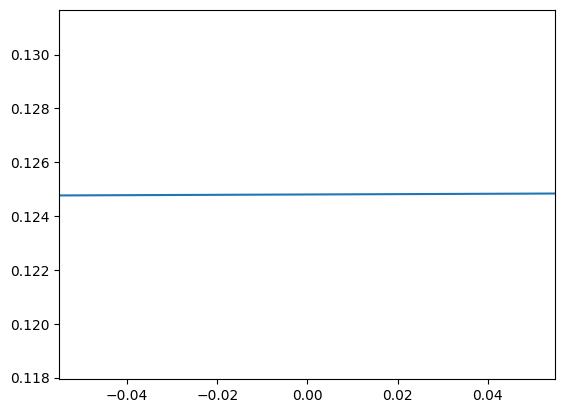

In [0]:
from scipy import stats
x = merge["index"]
y = merge["rain"]
m, b, *_ = stats.linregress(x, y)
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')

In [0]:
merge

my_date  index  ...  cloud_cover  wind_speed_10m
0       2012-01-01 00:00:00    0.5  ...    57.599998       20.466246
1       2012-01-01 01:00:00    0.0  ...    41.399998       22.039528
2       2012-01-01 02:00:00    0.0  ...    63.000000       23.051247
3       2012-01-01 03:00:00    0.0  ...    59.399998       23.950148
4       2012-01-01 04:00:00    0.0  ...    34.200001       25.202570
...                     ...    ...  ...          ...             ...
102778  2024-09-30 19:00:00    5.5  ...   100.000000       36.571907
102779  2024-09-30 20:00:00    4.5  ...   100.000000       36.734993
102780  2024-09-30 21:00:00    5.0  ...    82.500000       36.708084
102781  2024-09-30 22:00:00    4.0  ...    62.400002       34.699406
102782  2024-09-30 23:00:00    3.0  ...   100.000000       36.465885

[102783 rows x 6 columns]

In [0]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = merge["index"].values
y = merge["rain"].values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4580
Date:                Thu, 24 Oct 2024   Prob (F-statistic):              0.499
Time:                        11:32:59   Log-Likelihood:            -1.0516e+05
No. Observations:              102783   AIC:                         2.103e+05
Df Residuals:                  102781   BIC:                         2.103e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1248      0.004     33.357      0.0

In [0]:
lm = LinearRegression()
lm.fit(X, y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
print(myDF3)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
File <command-3507748381827247>, line 2
      1 lm = LinearRegression()
----> 2 lm.fit(X, y)
      3 params = np.append(lm.intercept_,lm.coef_)
      4 predictions = lm.predict(X)

File /databricks/python_shell/dbruntime/MLWorkloadsInstrumentation/_sklearn.py:29, in _create_patch_function.<locals>.patch_function(self, *args, **kwargs)
     27 try:
     28     original_succeeded = False
---> 29     original_result = original(self, *args, **kwargs)
     30     original_succeeded = True
     31     return original_result

File /databricks/python/lib/python3.11/site-packages/sklearn/base.py:1151, in _fit_context.<locals>.decorator.<locals>.wrapper(estimator, *args, **kwargs)
   1144     estimator._validate_params()
   1146 with config_context(
   1147     skip_parameter_validation=(
   1148         prefer_skip_nested_validation or global_sk